In [9]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns


In [ ]:
# 0-->neg and 1-->pos
def docs_to_bow(positive_instances, negative_instances, vocab):
    vocab_index = {word: i for i, word in enumerate(list(vocab))}
    def single_doc_bow(instance):
        v = np.zeros(len(vocab), dtype=int)
        for word in instance:
            if word in vocab_index:
                v[vocab_index[word]] += 1
        return v
    return np.array([single_doc_bow(review) for review in positive_instances]), np.array([single_doc_bow(review) for review in negative_instances])


def train_multinomial_nb(pos_bow, neg_bow):
    total_docs = len(pos_bow) + len(neg_bow)
    prob_pos = len(pos_bow) / total_docs
    prob_neg = len(neg_bow) / total_docs
    count_words_pos = np.sum(pos_bow, axis=0)
    count_words_neg = np.sum(neg_bow, axis=0)
    total_words_pos = np.sum(count_words_pos)
    total_words_neg = np.sum(count_words_neg)
    return prob_pos, prob_neg, (count_words_pos / total_words_pos), (count_words_neg / total_words_neg)


def predict(test_bow, prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg, log_state):
    if log_state:
        log_likelihood_pos = np.log(np.where(cond_prob_given_pos == 0, 1e-8, cond_prob_given_pos))
        log_likelihood_neg = np.log(np.where(cond_prob_given_neg == 0, 1e-8, cond_prob_given_neg))
        pos_results = np.dot(test_bow, log_likelihood_pos) + np.log(prob_pos)
        neg_results = np.dot(test_bow, log_likelihood_neg) + np.log(prob_neg)
        return np.where(pos_results > neg_results, 1, 0)
    else:
        pos_results = np.dot(test_bow, cond_prob_given_pos) * prob_pos
        neg_results = np.dot(test_bow, cond_prob_given_neg) * prob_neg
        return np.where(pos_results > neg_results, 1, 0)

In [10]:
def confusion_matrix(true, pred):
    TN, FP, FN, TP = 0, 0, 0, 0
    for t, p in zip(true, pred):
        if t == 0 and p == 0:
            TN += 1
        elif t == 0 and p == 1:
            FP += 1
        elif t == 1 and p == 0:
            FN += 1
        elif t == 1 and p == 1:
            TP += 1
    return TN, FP, FN, TP

def accuracy(TN, FP, FN, TP):
    return (TN + TP) / (TP + FN + TN + FP)

def precision(TP, FP):
    if TP + FP > 0:
        return TP / (TP + FP)
    return 0

def recall(TP, FN):
    if TP + FN > 0:
        return TP / (TP + FN)
    return 0

In [ ]:
percentage_positives, percentage_negatives = 0.2, 0.2
pos_train, neg_train, vocab = load_training_set(percentage_positives, percentage_negatives)
pos_test, neg_test = load_test_set(percentage_positives, percentage_negatives)
pos_bow_train, neg_bow_train = docs_to_bow(pos_train, neg_train, vocab)
pos_bow_test, neg_bow_test = docs_to_bow(pos_test, neg_test, vocab)
reviews_test = np.vstack([pos_bow_test, neg_bow_test])
labels_test = np.array([1] * len(pos_bow_test) + [0] * len(neg_bow_test))
prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg = train_multinomial_nb(pos_bow_train, neg_bow_train)
predictions_standard = predict(reviews_test, prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg, log_state=False)
TN, FP, FN, TP = confusion_matrix(labels_test, predictions_standard)
accuracy_std = accuracy(TN, FP, FN, TP)
precision_std = precision(TP, FP)
recall_std  = recall(TP, FN)

# using log
predictions_log = predict(reviews_test, prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg, log_state=True)
TN2, FP2, FN2, TP2 = confusion_matrix(labels_test, predictions_log)
accuracy_log = accuracy(TN2, FP2, FN2, TP2)
precision_log = precision(TP2, FP2)
recall_log  = recall(TP2, FN2)

# printing results
print("Standard Equation:\n Probabilities: Accuracy={}, Precision={}, Recall={}, Confusion Matrix: TN={}, FP={}, FN={}, TP={} \n".format(accuracy_std, precision_std, recall_std, TN, FP, FN, TP))
print("Log transformation trick:\n Probabilities: Accuracy={}, Precision={}, Recall={}, Confusion Matrix: TN={}, FP={}, FN={}, TP={} \n".format(accuracy_log, precision_log, recall_log, TN2, FP2, FN2, TP2))

Standard Equation:
 Probabilities: Accuracy=0.7102431247508968, Precision=0.7703198741478763, Recall=0.5911468812877264, Confusion Matrix: TN=2095, FP=438, FN=1016, TP=1469 

Log transformation trick:
 Probabilities: Accuracy=0.7640494220805102, Precision=0.7778727039726613, Recall=0.7327967806841046, Confusion Matrix: TN=2013, FP=520, FN=664, TP=1821 



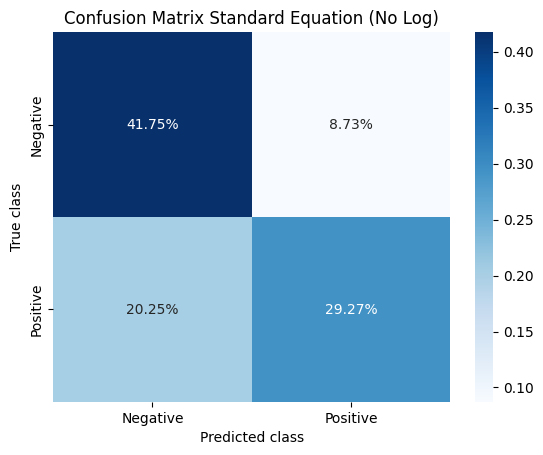

In [ ]:
cf_matrix_std = np.array([[TN, FP], [FN, TP]])
sns.heatmap(cf_matrix_std/np.sum(cf_matrix_std), annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix Standard Equation (No Log)')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'], va='center')
plt.show()

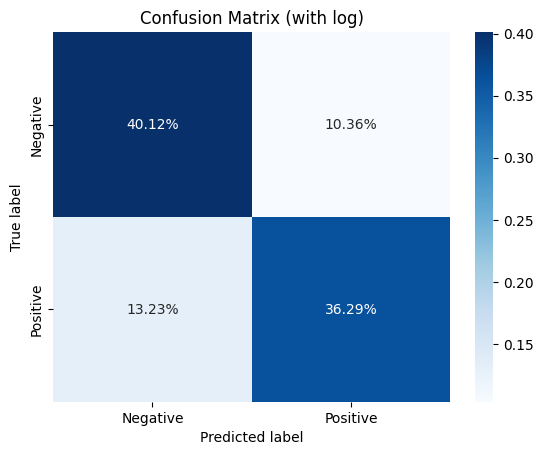

In [ ]:
cf_matrix_log = np.array([[TN2, FP2], [FN2, TP2]])
sns.heatmap(cf_matrix_log/np.sum(cf_matrix_log), annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (with log)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'], va='center')
plt.show()

Using 20% of the training set and 20% of the test set (balanced dataset same pecentage of pos and neg):
1) For the standard equation we obtained:
Accuracy=0.7102431247508968, Precision=0.7703198741478763, Recall=0.5911468812877264, Confusion Matrix: TN=2095, FP=438, FN=1016, TP=1469 

2) For the Log transformation trick we obtained:
Accuracy=0.7640494220805102, Precision=0.7778727039726613, Recall=0.7327967806841046, Confusion Matrix: TN=2013, FP=520, FN=664, TP=1821 

Using the results from both equations that we can see above and with the help of our plots we can see first and foremost that the accuracy of our model increased from 71% to 76% when we used log which shows that our model using log is better at identifying instances of both neg and pos class. We can see a big change in our recall too going from 59% without log to 73% with log. From lecture we know that recall computes the probability of the model of finding all objects of a target class that is percentage of correct classifications when considering the positive class in our case (TP/(TP+FN)). This change happens because when using the log we have less  FN and more TP so we are more accurately predicting the positive class. This is due because of numerical issues/instability in the standard equation  since it requires computing the product of hundreds of small terms—which makes this probability estimate rapidly approach zero hence making our model less accurate compared when taking the log where we are transforming the product of these terms into a sum avoiding all sorts of numerical problems. Importantly, using log does not change which class is more likely according to the trained model.
We can deduce that recall is sensitive to false negatives, and the standard equation seems to incorrectly classify positive instances as negative, hence increasing false negatives. Using log fixes that problem.
Our Precision seems to stay the same around 77% for both equations so we can say that the increase in TP and FP was proportional didn't affect our precision here. The log trick didn't manage to reduce the FP rate we can see that there is actually a sligh increase in our FP rates.
We can sum up by saying that it's important to use log probabilities, espicially if we want a high recall from our model and if we want to address numerical instabilities.

**Q2**

In [11]:
# 0-->neg and 1-->pos
def docs_to_bow(positive_instances, negative_instances, vocab):
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
    def single_doc_bow(instance):
        v = np.zeros(len(vocab), dtype=np.int16)
        for word in instance:
            if word in vocab_index:
                v[vocab_index[word]] += 1
        return v
    pos_bow = np.array([single_doc_bow(review) for review in positive_instances])
    neg_bow = np.array([single_doc_bow(review) for review in negative_instances])
    return pos_bow, neg_bow


def train_naive_bayes_with_smoothing(pos_bow, neg_bow, vocab_size, alpha=1):
    total_docs = len(pos_bow) + len(neg_bow)
    prob_pos = len(pos_bow) / total_docs
    prob_neg = len(neg_bow) / total_docs
    count_pos = np.sum(pos_bow, axis=0)
    count_neg = np.sum(neg_bow, axis=0)
    cond_prob_given_pos = (count_pos + alpha) / (np.sum(count_pos) + alpha * vocab_size)
    cond_prob_given_neg = (count_neg + alpha) / (np.sum(count_neg) + alpha * vocab_size)

    return prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg


def predict(test_bow, prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg, log_state=False):
    if log_state:
        log_likelihood_pos = np.log(np.where(cond_prob_given_pos == 0, 1e-8, cond_prob_given_pos))
        log_likelihood_neg = np.log(np.where(cond_prob_given_neg== 0, 1e-8, cond_prob_given_neg))
        log_prob_pos = np.log(prob_pos)
        log_prob_neg = np.log(prob_neg)
        pos_results = np.dot(test_bow, log_likelihood_pos) + log_prob_pos
        neg_results = np.dot(test_bow, log_likelihood_neg) + log_prob_neg
        return np.where(pos_results > neg_results, 1, 0)
    else:
        pos_results = np.dot(test_bow, cond_prob_given_pos) * prob_pos
        neg_results = np.dot(test_bow, cond_prob_given_neg) * prob_neg
        return np.where(pos_results > neg_results, 1, 0)

In [ ]:
percentage_positives, percentage_negatives = 0.2, 0.2
pos_train, neg_train, vocab = load_training_set(percentage_positives, percentage_negatives)
pos_test, neg_test = load_test_set(percentage_positives, percentage_negatives)
pos_bow_train, neg_bow_train = docs_to_bow(pos_train, neg_train, vocab)
pos_bow_test, neg_bow_test = docs_to_bow(pos_test, neg_test, vocab)
reviews_test = np.vstack([pos_bow_test, neg_bow_test])
labels_test = np.array([1] * len(pos_bow_test) + [0] * len(neg_bow_test))
prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg = train_naive_bayes_with_smoothing(pos_bow_train, neg_bow_train, len(vocab), 1)
predictions_alpha1 = predict(reviews_test, prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg, log_state=True)
TN_alpha1, FP_alpha1, FN_alpha1, TP_alpha1 = confusion_matrix(labels_test, predictions_alpha1)
accuracy_alpha1 = accuracy(TN, FP, FN, TP)
precision_alpha1 = precision(TP, FP)
recall_alpha1  = recall(TP, FN)
print("With alpha set equal to 1:\n Probabilities: Accuracy={}, Precision={}, Recall={}, Confusion Matrix: TN={}, FP={}, FN={}, TP={} \n".format(accuracy_std, precision_std, recall_std, TN, FP, FN, TP))

With alpha set equal to 1:
 Probabilities: Accuracy=0.7102431247508968, Precision=0.7703198741478763, Recall=0.5911468812877264, Confusion Matrix: TN=2095, FP=438, FN=1016, TP=1469 



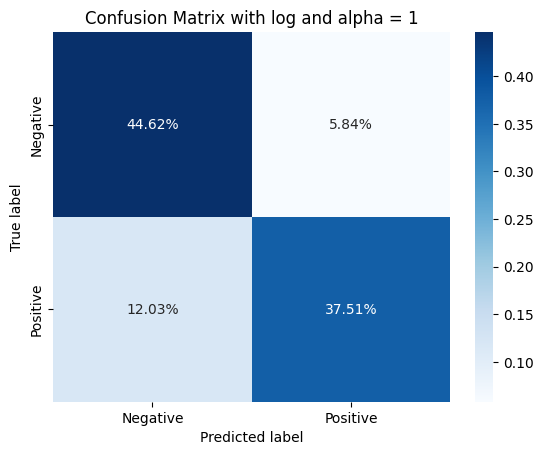

In [ ]:
cf_matrix_alpha1 = np.array([[TN_alpha1, FP_alpha1], [FN_alpha1, TP_alpha1]])
sns.heatmap(cf_matrix_alpha1/np.sum(cf_matrix_alpha1), annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix with log and alpha = 1')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'], va='center')
plt.show()

In [ ]:

percentage_positives, percentage_negatives = 0.2, 0.2
pos_train, neg_train, vocab = load_training_set(percentage_positives, percentage_negatives)
pos_test, neg_test = load_test_set(percentage_positives, percentage_negatives)
pos_bow_train, neg_bow_train = docs_to_bow(pos_train, neg_train, vocab)
pos_bow_test, neg_bow_test = docs_to_bow(pos_test, neg_test, vocab)
reviews_test = np.vstack([pos_bow_test, neg_bow_test])
labels_test = np.array([1] * len(pos_bow_test) + [0] * len(neg_bow_test))
accuracies = []
alpha = 0.0001
while alpha<= 1000:
    prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg = train_naive_bayes_with_smoothing(pos_bow_train, neg_bow_train, len(vocab), alpha)
    predictions_alphas = predict(reviews_test, prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg, log_state=True)
    accuracy = np.mean(predictions_alphas == labels_test)
    accuracies.append(accuracy)
    alpha*=10

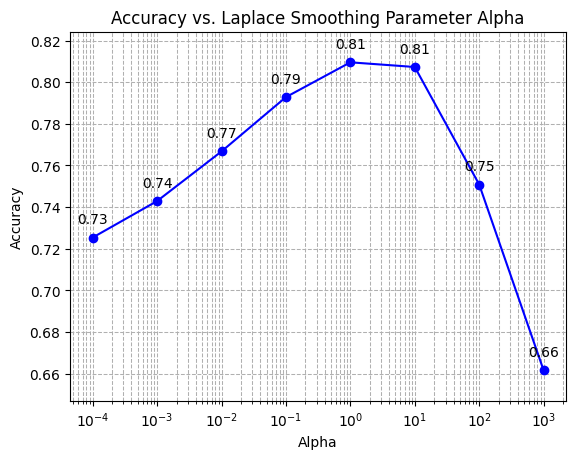

In [ ]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000]
plt.semilogx(alphas, accuracies, marker='o', linestyle='-', color='blue')
plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Laplace Smoothing Parameter Alpha')
min_acc, max_acc = min(accuracies), max(accuracies)
plt.ylim([min_acc - (max_acc - min_acc) * 0.1, max_acc + (max_acc - min_acc) * 0.1])
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2f}', (alphas[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

We use Laplace smoothing because sometimes we might encounter a word in the test instance that is not part of our vocabulary that we identified during training. Let's say this word is w1 then we will have P(w1|positive)=0 and P(w1|negative)=0, but this will make both P(positive|review) and P(negative|review) equal to 0 since we multiply all the likelihoods. Even when using the log trick it's still an issue because if any of the probabilities is 0, log(0) is undefined (goes to -inf); in our case we specified a small constant 1e-8 to deal with that case but Laplace Smoothing usually solves this issue.
Using 20% of the training set and 20% of the test set (balanced dataset same pecentage of pos and neg):
We got for alpha = 1: 
Accuracy=0.7102431247508968, Precision=0.7703198741478763, Recall=0.5911468812877264, Confusion Matrix: TN=2095, FP=438, FN=1016, TP=1469

Now retraining our model and varying the value of alpha from 0.0001 to 1000, by multiplying α with 10 each time, recording the accuracy at each value we get the graph.
 
Analyzing the graph above we can see that the accuracy reaches a maximum for alpha equals 1 and 10. The more we increase alpha the better the accuracy gets until we reach our maximum then it starts dropping drastically until it reaches 66% for an alpha value of 1000. The reason why accuracy suffers for high values of alpha is because although that value solves the problem of zero frequency of words, it also strongly biases the model to "believe" that the word aooears mych more frequently than it actually does making predictions less accurate. The reason why it suffers for small values of alpha is because the smoothing is still negligeable in other words the model is still sensitive to the exact frequencies of words in our training set, so there is some sort of overfitting where the model isn't generalizing well to unseen words making it less accurate. This is a big dataset with a large vocabulary, the probability of that new word for small values of alpha will be so low which will lead to the poor accuracy we're observing too.

Laplace smoothing allows the model to handle new and unseen data, it also helps the model to generalize better to new data. Using alpha = 1 is common, and it also resulted in the best overall accuracy/performance here in our case.


**Q3**

In [12]:

percentage_positives, percentage_negatives = 1.0, 1.0
pos_train, neg_train, vocab = load_training_set(percentage_positives, percentage_negatives)
pos_test, neg_test = load_test_set(percentage_positives, percentage_negatives)
pos_bow_train, neg_bow_train = docs_to_bow(pos_train, neg_train, vocab)
pos_bow_test, neg_bow_test = docs_to_bow(pos_test, neg_test, vocab)
reviews_test = np.vstack([pos_bow_test, neg_bow_test])
labels_test = np.array([1] * len(pos_bow_test) + [0] * len(neg_bow_test))


In [13]:
prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg = train_naive_bayes_with_smoothing(pos_bow_train, neg_bow_train, len(vocab), 1)
predictions = predict(reviews_test, prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg, log_state=True)
TN_full, FP_full, FN_full, TP_full = confusion_matrix(labels_test, predictions)
accuracy_full = accuracy(TN_full, FP_full, FN_full, TP_full)
precision_full = precision(TP_full, FP_full)
recall_full  = recall(TP_full, FN_full)
print("100% training set 100% testing set Probabilities: Accuracy={}, Precision={}, Recall={}, Confusion Matrix: TN={}, FP={}, FN={}, TP={} \n".format(accuracy_full, precision_full, recall_full, TN_full, FP_full, FN_full, TP_full))

100% training set 100% testing set Probabilities: Accuracy=0.82352, Precision=0.8651797001986635, Recall=0.76648, Confusion Matrix: TN=11007, FP=1493, FN=2919, TP=9581 



Using 100% of the training set and 100% of the test set and alpha=1 (balanced dataset same pecentage of pos and neg):
Accuracy=0.82352, Precision=0.8651797001986635, Recall=0.76648, Confusion Matrix: TN=11007, FP=1493, FN=2919, TP=9581
(The confusion matrix plot is shown in q4 comparing it with when using 50% of training set).

We can see that we have an increase in accuracy when using 100% of the data compared 20%. With 100% of the training set, the model has access to more examples for each class allowing for a better generalization when making prediction, as it's more likely to have encountered similar instances during training. With a bigger training dataset there is less sensitivity to noise and hence less overfitting.

We also see an increase in precision because with more training data, the model gets better at distinguishing between positive and negative instances, reducing the number of FP which contributes to higher precision. Same for the increese in recall, model gets better in edge cases reducing the number of FN, it gets better at recognizing positive instances.

**Q4**

In [14]:

percentage_positives_training, percentage_negatives_training = 0.5, 0.5
percentage_positives_testing, percentage_negatives_testing = 1.0, 1.0
pos_train, neg_train, vocab = load_training_set(percentage_positives_training, percentage_negatives_training)
pos_test, neg_test = load_test_set(percentage_positives_testing, percentage_negatives_testing)
pos_bow_train, neg_bow_train = docs_to_bow(pos_train, neg_train, vocab)
pos_bow_test, neg_bow_test = docs_to_bow(pos_test, neg_test, vocab)
reviews_test = np.vstack([pos_bow_test, neg_bow_test])
labels_test = np.array([1] * len(pos_bow_test) + [0] * len(neg_bow_test))


In [15]:
prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg = train_naive_bayes_with_smoothing(pos_bow_train, neg_bow_train, len(vocab), 1)
predictions = predict(reviews_test, prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg, log_state=True)
TN_half, FP_half, FN_half, TP_half = confusion_matrix(labels_test, predictions)
accuracy_half = accuracy(TN_half, FP_half, FN_half, TP_half)
precision_half = precision(TP_half, FP_half)
recall_half  = recall(TP_half, FN_half)
print("50% training set 100% testing set Probabilities: Accuracy={}, Precision={}, Recall={}, Confusion Matrix: TN={}, FP={}, FN={}, TP={} \n".format(accuracy_half, precision_half, recall_half, TN_half, FP_half, FN_half, TP_half))

50% training set 100% testing set Probabilities: Accuracy=0.82128, Precision=0.8649581970192657, Recall=0.76144, Confusion Matrix: TN=11014, FP=1486, FN=2982, TP=9518 



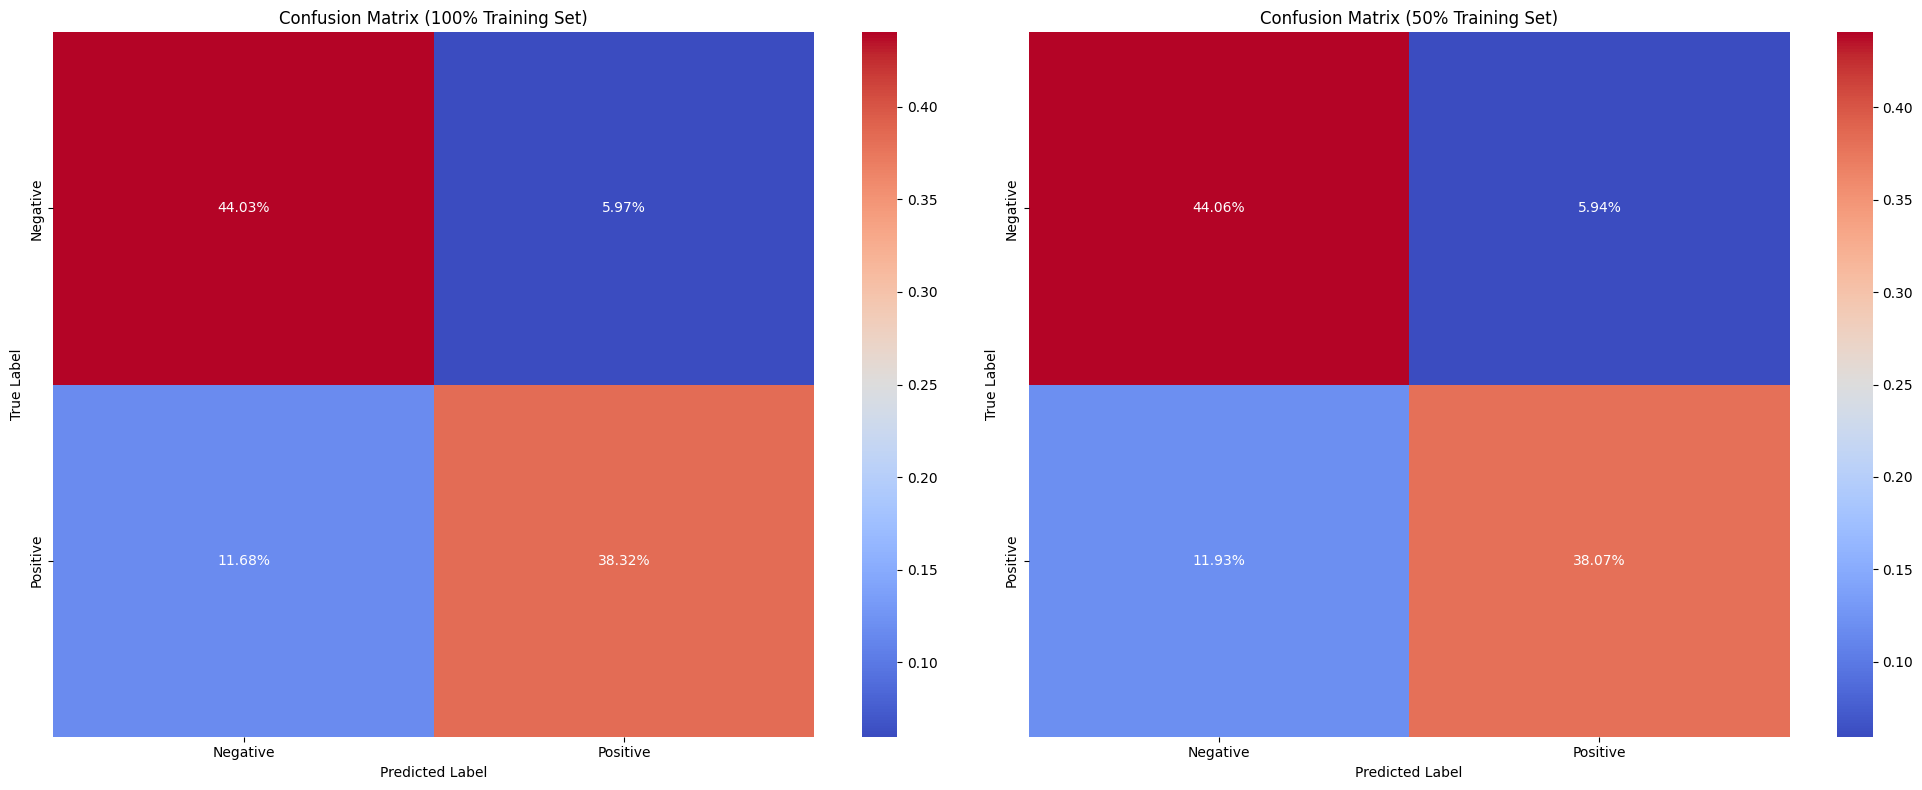

In [28]:
cf_matrix_full = np.array([[TN_full, FP_full], [FN_full, TP_full]])
cf_matrix_half = np.array([[TN_half, FP_half], [FN_half, TP_half]])
plt.figure(figsize=(20, 8))
def plot_cf_matrix(cf_matrix, title, ax):
    sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='coolwarm', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'], va='center')
ax1 = plt.subplot(1, 2, 1)
plot_cf_matrix(cf_matrix_full, 'Confusion Matrix (100% Training Set)', ax1)
ax2 = plt.subplot(1, 2, 2)
plot_cf_matrix(cf_matrix_half, 'Confusion Matrix (50% Training Set)', ax2)
plt.tight_layout()
plt.show()

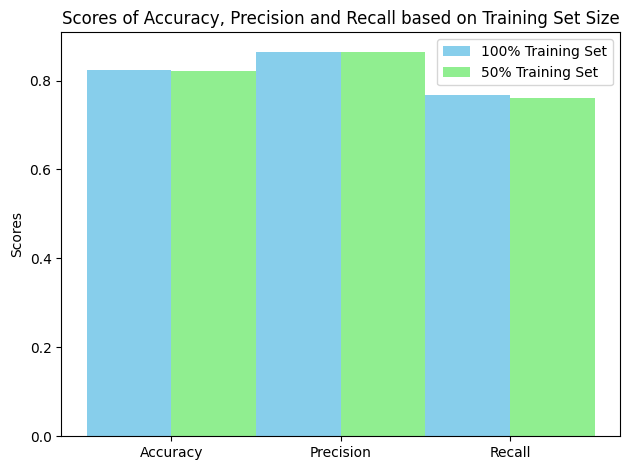

In [24]:
m = ['Accuracy', 'Precision', 'Recall']
values_full = [accuracy_full, precision_full, recall_full]
values_half = [accuracy_half, precision_half, recall_half]
x = np.arange(len(m))
fig, ax = plt.subplots()
bars1 = ax.bar(x - 0.5/2, values_full, 0.5, label='100% Training Set', color='skyblue')
bars2 = ax.bar(x + 0.5/2, values_half, 0.5, label='50% Training Set', color='lightgreen')
ax.set_ylabel('Scores')
ax.set_title('Scores of Accuracy, Precision and Recall based on Training Set Size')
ax.set_xticks(x)
ax.set_xticklabels(m)
ax.legend()
fig.tight_layout()
plt.show()

Using 50% of the training set and 100% of the test set and alpha=1 (balanced dataset same pecentage of pos and neg):
Accuracy=0.82128, Precision=0.8649581970192657, Recall=0.76144, Confusion Matrix: TN=11014, FP=1486, FN=2982, TP=9518 

We saw in Q3 that using 100% of the training set and 100% of the test set and alpha=1 (balanced dataset same pecentage of pos and neg):
Accuracy=0.82352, Precision=0.8651797001986635, Recall=0.76648, Confusion Matrix: TN=11007, FP=1493, FN=2919, TP=9581

It doesn't seem like using a smaller training dataset affected the model's performance. There's negligeable improvement when we use 100% of the training set but nothing worth noting. This might be because our 50% of our trainig data is still a lot of data and the quality of the data collected is good (representation etc.), so the model is able to generalize well to new unseen instances which shows robustness and hence we don't really need to use all of our training set here. In my opinion and I'm not an expert it's not worth the time and memory to train it on 100% of the training set if using half of the set performs nearly as well and seems to be doing a solid job. So,using the full training dataset might not always be the most practical choice due to the trade offs between improved model performance and the increased demands on time and computational resources. Larger datasets can enhance a model's accuracy and its ability to generalize, but they also require more processing power and longer training periods. This could become an issue, especially in scenarios where resources are limited.

Analyzing the confusion matrices above of both 100% and 50% of training sets as well as the histogram plot showing accuracy, precision and recall we can see we have somewhat similar rates of TN (44.03% for 100% and 44.06% for 50%) and similar rates of TP(38.32% for 100% and 38.07% for 50%). This suggests that there wasn't an impact on specific classes, if the changes in precision and recall were more relevant that would suggest that one class (positive or negative) was more affected by the reduction in training data size. But it doesn't seem to be the case here Which explains why in the histograms the bars of the two models have almost the same height (scores) for accuracy, precision and recall.

**Q5**

In this application (i.e., accurately classifying movie reviews), I would say it's more important to have high precision . However, it goes back to what we're actually trying to achieve, what's our end goal and what's more important to us this is why I don't think there's one correct answer for this question. So my reasoning for choosing high precision is because we don't want to recommend a bad movie that has negative reviews to users; this has the worst potential outcome out of all the options. I know that I wouldn't be happy if I was told that a movie has positive reviews and it turned out to be a bad one. So we try to minimize the FP instances as much as possible since precision measures the proportion of actual positive reviews among those classified as positive. On the other hand, if we care about balancing the performance without favoring any class (which I have to say doesn't make sense here because why would we care for negative reviews, no one going to a movie with negative reviews would be disappointed if it turned out good) high accuracy would be important since accuracy measures the proportion of true results for both classes in the entire dataset. Finally, having a high recall is also important but not as much here, since it's main goal is to capture the proportion of positive reviews that we were able to correctly identify.

**Q6**

In [25]:
percentage_positives_training, percentage_negatives_training = 0.1, 0.5
percentage_positives_testing, percentage_negatives_testing = 1.0, 1.0
pos_train, neg_train, vocab = load_training_set(percentage_positives_training, percentage_negatives_training)
pos_test, neg_test = load_test_set(percentage_positives_testing, percentage_negatives_testing)
pos_bow_train, neg_bow_train = docs_to_bow(pos_train, neg_train, vocab)
pos_bow_test, neg_bow_test = docs_to_bow(pos_test, neg_test, vocab)
reviews_test = np.vstack([pos_bow_test, neg_bow_test])
labels_test = np.array([1] * len(pos_bow_test) + [0] * len(neg_bow_test))


In [27]:
prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg = train_naive_bayes_with_smoothing(pos_bow_train, neg_bow_train, len(vocab), 1)
predictions = predict(reviews_test, prob_pos, prob_neg, cond_prob_given_pos, cond_prob_given_neg, log_state=True)
TN_unbalanced, FP_unbalanced, FN_unbalanced, TP_unbalanced = confusion_matrix(labels_test, predictions)
accuracy_unbalanced = accuracy(TN_unbalanced, FP_unbalanced, FN_unbalanced, TP_unbalanced)
precision_unbalanced = precision(TP_unbalanced, FP_unbalanced)
recall_unbalanced  = recall(TP_unbalanced, FN_unbalanced)
print("10% of the available positive training instances and 50% of the available negative training instances. 100% testing set:\nProbabilities: Accuracy={}, Precision={}, Recall={}, Confusion Matrix: TN={}, FP={}, FN={}, TP={} \n".format(accuracy_unbalanced, precision_unbalanced, recall_unbalanced, TN_unbalanced, FP_unbalanced, FN_unbalanced, TP_unbalanced))

10% of the available positive training instances and 50% of the available negative training instances. 100% testing set:
Probabilities: Accuracy=0.59476, Precision=0.9522718594883544, Recall=0.19952, Confusion Matrix: TN=12375, FP=125, FN=10006, TP=2494 



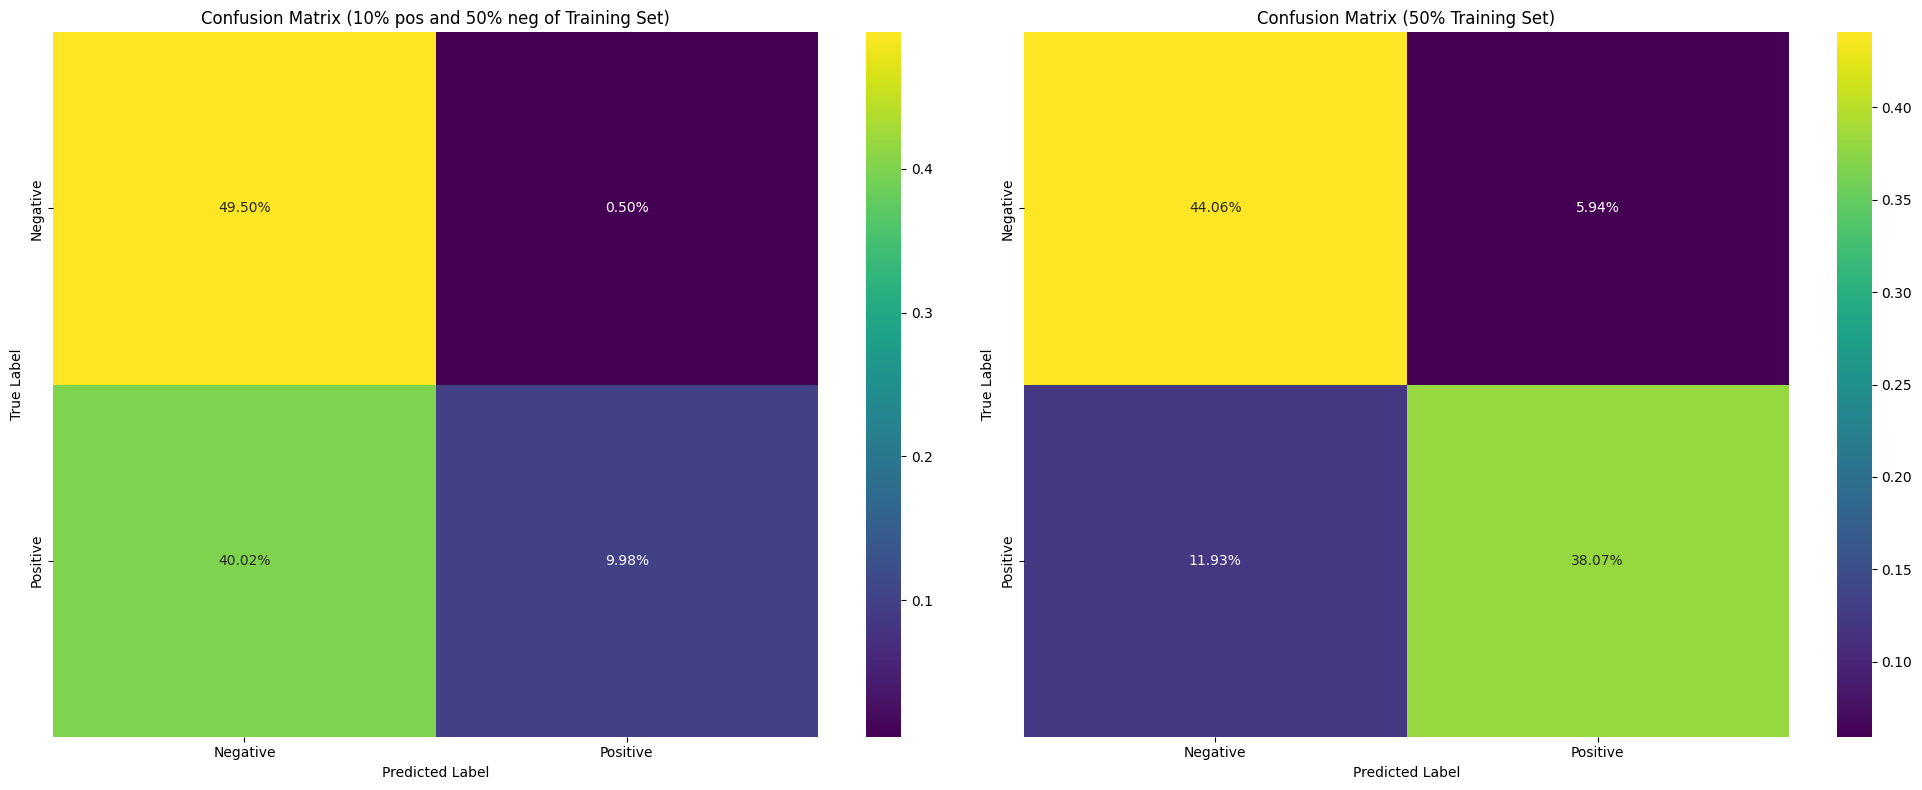

In [30]:
cf_matrix_unbalanced = np.array([[TN_unbalanced, FP_unbalanced], [FN_unbalanced, TP_unbalanced]])
plt.figure(figsize=(20, 8))
def plot_cf_matrix(cf_matrix, title, ax):
    sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='viridis', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'], va='center')
ax1 = plt.subplot(1, 2, 1)
plot_cf_matrix(cf_matrix_unbalanced, 'Confusion Matrix (10% pos and 50% neg of Training Set)', ax1)
ax2 = plt.subplot(1, 2, 2)
plot_cf_matrix(cf_matrix_half, 'Confusion Matrix (50% Training Set)', ax2)
plt.tight_layout()
plt.show()

Using 50% of the available negative training instances and 10% of the available positive training instances (0.1, 0.5), we got:
Accuracy=0.59476, Precision=0.9522718594883544, Recall=0.19952, Confusion Matrix: TN=12375, FP=125, FN=10006, TP=2494 

We can see a significant drop in accuracy in our model (59%) compared to our model in Q4 (82%). This is why during class when we talked about accuracy we said that on its own, it might not be a good performance metric. In this case we have an imbalanced dataset so the model that was trained on this imbalanced set will predict the majority class which on our case is the negative and this will result in poor performance on the minority class (positive class here). So, accuracy can be misleading sometimes.

We can see that our recall here is really low 19% compared to our recall in Q4 76%. Same reason as before since the positive class is the minority class here we will have poor predicitons and it's reflected with the increase in FN (40%) compared to the (11%) we had previously. The low value here indicates that the model failed to identify a significant portion of positive reviews, underscoring the model's tendency in perdicting based on the dominant class (negative here).

Precision got higher (95% compared to the previous 86%) because we barely have any FP instances anymore (0.5%) because the model keeps prediting negative the majority of the time. Again this shows the model's reluctance to classify instances as positive, aligning with its bias towards the majority (negative) class. We shouldn't be tricked into thinking that this is indicative of good performance this is due to the fact that the model's not predicting the minority class therefore leading to a high number of missed positive classifications.